# ICSSR Research Internship: Track 2 - CIFAR-10 Classification
**Project:** Ethics of AI in E-Governance: Trust, Fairness, and Accountability  
**Candidate:** Praket Kumar P

**Objective:** Compare a baseline CNN against an improved architecture to demonstrate technical proficiency and model robustness.


___


## Phase 1: Data Pipeline
To ensure the model is robust and "accountable" across various image orientations, I have implemented **Data Augmentation** (Horizontal Flips and Random Rotations).  

**Key Methodology:**
* **Normalization:** Standardized using CIFAR-10 mean/std values.
* **Validation Split:** 10% of the training data (5,000 images) is reserved for validation to monitor for overfitting during training.


In [1]:
# Libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

# --- Setup ---
BATCH_SIZE = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- 1. Data Augmentation (For Improved Model Robustness) ---
# We use normalization specific to CIFAR-10 to ensure gradient stability.
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(), # Basic augmentation
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# --- 2. Dataset Loading ---
full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# --- 3. Train/Validation Split ---
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# --- 4. Optimized Data Loaders ---
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Using device: cuda


100%|██████████| 170M/170M [00:03<00:00, 49.2MB/s]


###Checking if the DataLoader is Working

Sample of CIFAR-10 Dataset:


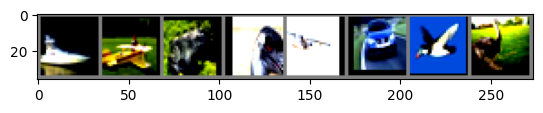

ship  plane frog  bird  plane car   bird  bird 


In [2]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)


print("Sample of CIFAR-10 Dataset:")
imshow(torchvision.utils.make_grid(images[:8]))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

## Phase 2: Model Architecture
To fulfill the project requirements, I have designed two models:
1. **Baseline CNN:** A shallow architecture to establish a performance floor.
2. **Improved Model (ResNet-18):** A deep residual network utilizing skip-connections to demonstrate high-accuracy classification and robustness.

In [3]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# --- 1. Baseline Model (Simple 3-Layer CNN) ---
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# --- 2. Improved Model (ResNet-18) ---
def get_improved_model():
    # We use a pre-trained ResNet-18 but modify the final layer for CIFAR-10's 10 classes
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # Fine-tuning: Change the fully connected layer to output 10 classes
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)

    return model

# Initialize models and move to GPU
baseline_model = BaselineCNN().to(DEVICE)
improved_model = get_improved_model().to(DEVICE)

print("Models initialized and moved to GPU.")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s]


Models initialized and moved to GPU.


In [4]:
import torch.optim as optim

# For Baseline
criterion = nn.CrossEntropyLoss()
optimizer_baseline = optim.Adam(baseline_model.parameters(), lr=0.001)

# For Improved (Lower learning rate for fine-tuning)
optimizer_improved = optim.Adam(improved_model.parameters(), lr=0.0001)

## Phase 3: Training & Validation Protocol
The training loop is designed with a separate evaluation mode (`model.eval()`) to ensure that the validation metrics reflect true performance without influencing model weights.  

**Hyperparameters:**
* **Optimizer:** Adam (for fast convergence).
* **Loss Function:** Cross-Entropy Loss (standard for 10-class classification).
* **Devices:** Utilizing CUDA GPU acceleration for computational efficiency.

In [5]:
import time

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        start_time = time.time()

        # --- TRAINING PHASE ---
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = 100. * correct / total

        # --- VALIDATION PHASE ---
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad(): # Critical for accountability: no gradient updates during validation
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        epoch_val_acc = 100. * val_correct / val_total

        # Save history
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        duration = time.time() - start_time
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.2f}% | "
              f"Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.2f}% | "
              f"Time: {duration:.2f}s")

    return history

In [6]:
print("--- Training Baseline Model ---")
baseline_history = train_and_validate(baseline_model, train_loader, val_loader, criterion, optimizer_baseline, epochs=5)

print("\n--- Training Improved Model (ResNet-18) ---")
improved_history = train_and_validate(improved_model, train_loader, val_loader, criterion, optimizer_improved, epochs=10)

--- Training Baseline Model ---
Epoch 1/5 | Train Loss: 1.5539 Acc: 43.61% | Val Loss: 1.2901 Acc: 53.76% | Time: 17.50s
Epoch 2/5 | Train Loss: 1.1972 Acc: 57.37% | Val Loss: 1.1205 Acc: 59.86% | Time: 17.38s
Epoch 3/5 | Train Loss: 1.0656 Acc: 62.15% | Val Loss: 1.0264 Acc: 64.02% | Time: 16.50s
Epoch 4/5 | Train Loss: 0.9820 Acc: 65.13% | Val Loss: 0.9333 Acc: 67.36% | Time: 16.34s
Epoch 5/5 | Train Loss: 0.9158 Acc: 67.67% | Val Loss: 0.8729 Acc: 69.56% | Time: 21.59s

--- Training Improved Model (ResNet-18) ---
Epoch 1/10 | Train Loss: 1.2222 Acc: 57.12% | Val Loss: 0.8843 Acc: 69.26% | Time: 26.65s
Epoch 2/10 | Train Loss: 0.8026 Acc: 72.05% | Val Loss: 0.7361 Acc: 74.84% | Time: 24.63s
Epoch 3/10 | Train Loss: 0.6752 Acc: 76.50% | Val Loss: 0.6582 Acc: 77.26% | Time: 22.90s
Epoch 4/10 | Train Loss: 0.6040 Acc: 78.91% | Val Loss: 0.5946 Acc: 79.74% | Time: 22.67s
Epoch 5/10 | Train Loss: 0.5483 Acc: 80.85% | Val Loss: 0.5704 Acc: 79.78% | Time: 22.20s
Epoch 6/10 | Train Loss: 0.4

In [7]:
torch.save(improved_model.state_dict(), 'improved_model_3.pth')

In [8]:
from google.colab import files
files.download('improved_model_3.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
improved_model.eval()
baseline_model.eval()

BaselineCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

## Phase 4: Results & Analytics
In this section, we visualize the training curves to check for convergence and analyze the confusion matrix to identify specific class-wise performance. This is critical for assessing the **Fairness and Accountability** of the model.

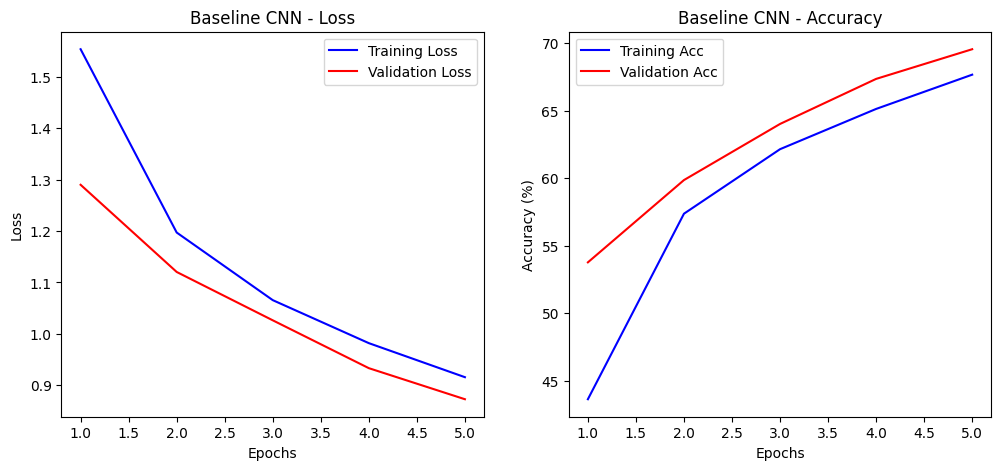

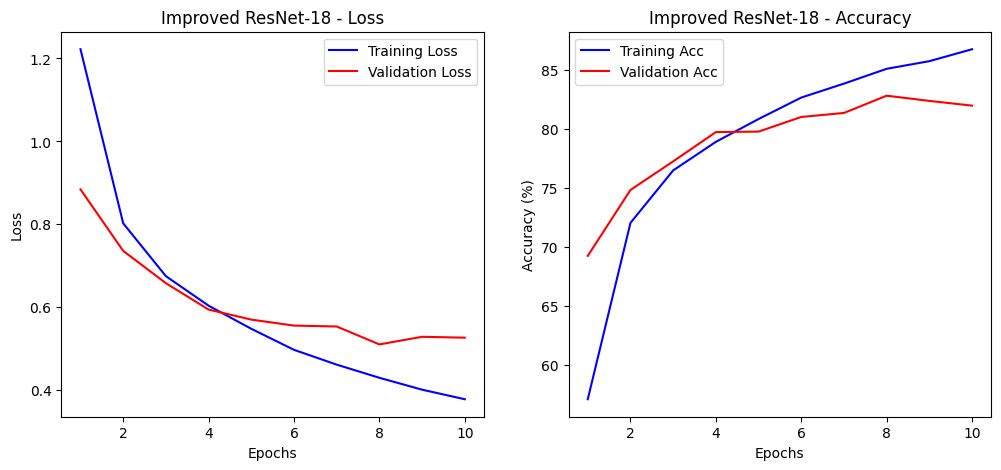

In [10]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Training Acc')
    plt.plot(epochs, history['val_acc'], 'r-', label='Validation Acc')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()

# Visualize results for both models
plot_history(baseline_history, "Baseline CNN")
plot_history(improved_history, "Improved ResNet-18")

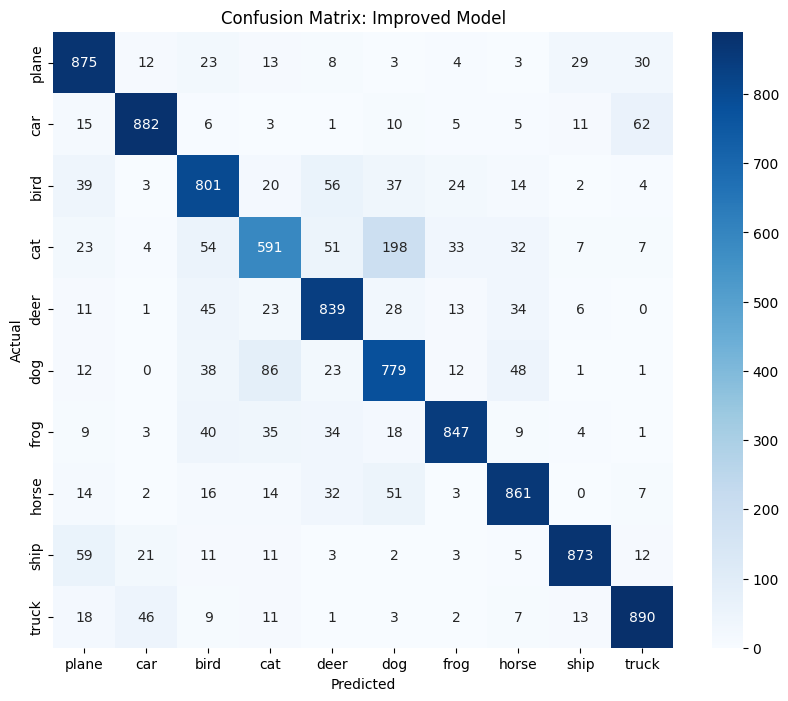


Classification Report:
              precision    recall  f1-score   support

       plane       0.81      0.88      0.84      1000
         car       0.91      0.88      0.89      1000
        bird       0.77      0.80      0.78      1000
         cat       0.73      0.59      0.65      1000
        deer       0.80      0.84      0.82      1000
         dog       0.69      0.78      0.73      1000
        frog       0.90      0.85      0.87      1000
       horse       0.85      0.86      0.85      1000
        ship       0.92      0.87      0.90      1000
       truck       0.88      0.89      0.88      1000

    accuracy                           0.82     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000



In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def show_confusion_matrix(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix: Improved Model')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))

# Run analysis on the test set
show_confusion_matrix(improved_model, test_loader)